In [1]:
library(ggplot2)
library(dplyr)
library(glue)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Sanity check simulating just two cell types

In [493]:
# Generate CT expression from standard normal for gene i
# Generate state expression that is dependent on CT expression
m = 1000
CT0 = rnorm(m) 
CT1 = rnorm(m)

# create CT indicator vector and STATE indicator vector
n = 10000
CT_ind = rep(0, n)
CT_ind[(n/2 + 1):n] = 1

In [494]:
# construct expression matrix 
z = matrix(0, n, m)

# populate with expression
for (i in 1:dim(z)[1]){
    if (CT_ind[i] == 0){
        z[i,] = z[i] + rnorm(CT0, mean=CT0, sd=1) 
        
    } else {
        z[i,] = z[i] + rnorm(CT1, mean=CT1, sd=1) 

    } 

}

In [495]:
pca = prcomp(z, scale=TRUE, center=TRUE) 

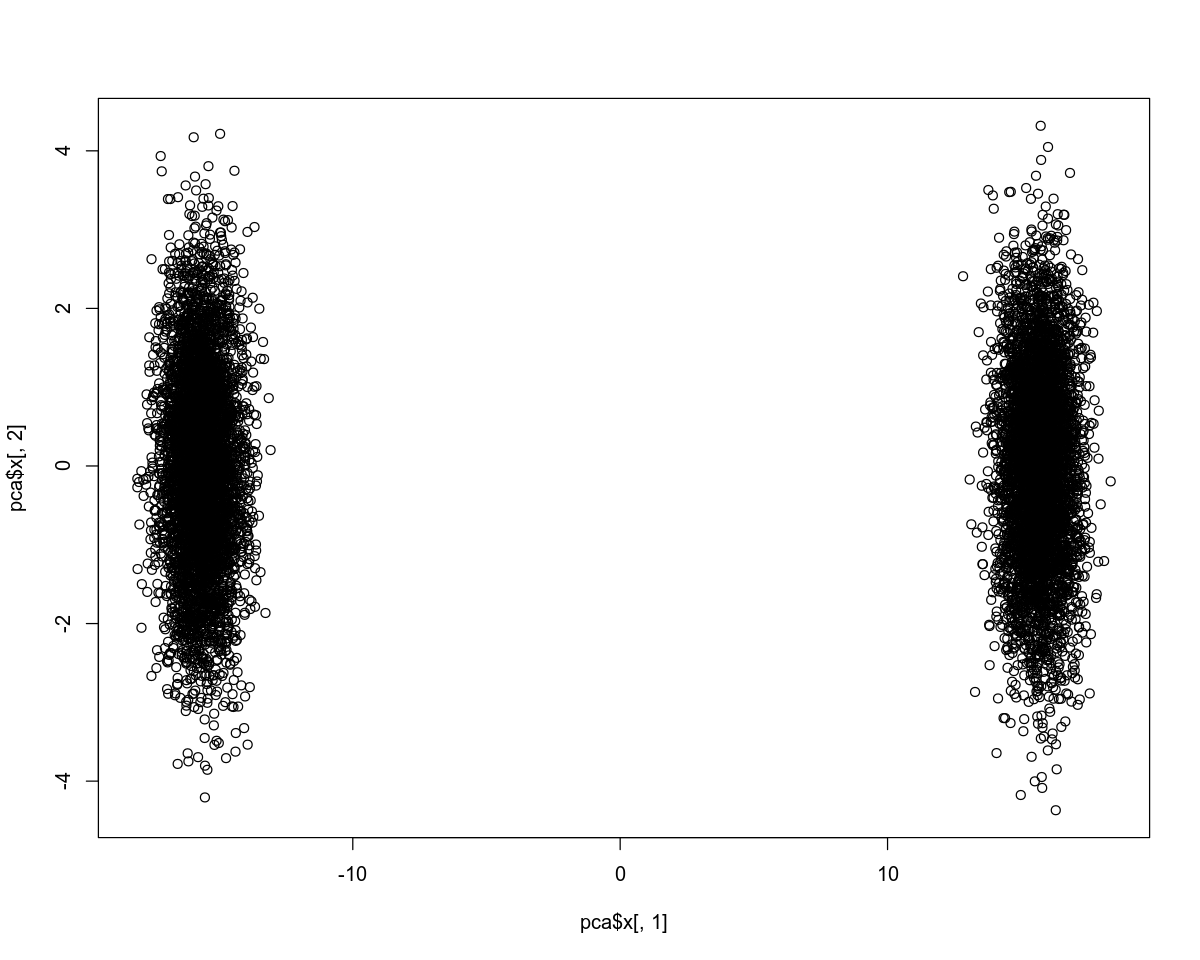

In [496]:
plot(pca$x[,1], pca$x[,2])

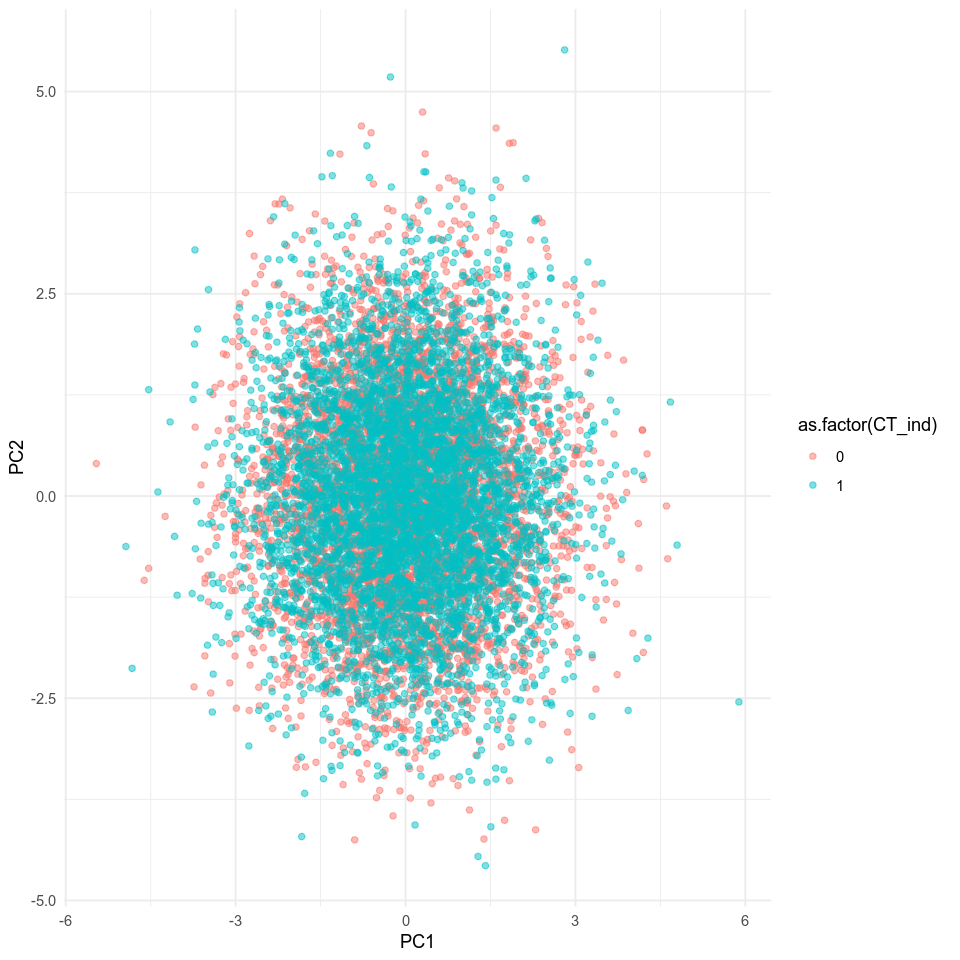

In [497]:
# residualize cell type from z
z_resid = matrix(0, n, m)
z = scale(z)
for (i in 1:m){
    # should be scaled and centered when taking residual
    alpha_hat_ct = lm(scale(z[,i]) ~ CT_ind)$coefficients[[2]]
    z_resid[,i] = z[,i] - (CT_ind * alpha_hat_ct)
    #z_resid[,i] = lm(scale(z[,i]) ~ CT_ind)$residuals
    
}

pca = prcomp(z_resid, scale=TRUE, center=TRUE) 

options(repr.plot.width=8, repr.plot.height=8)
ggplot(data.frame(pca$x), aes(x=PC1, y=PC2, color=as.factor(CT_ind) )) + geom_point(alpha=0.5) + theme_minimal()



# Simulating two cell types + state, only cell type 0 can occupy state, in this simulation when you allow 100% of the genes to be in a given cell type, you intuitively are creating a third cell type, no continuums in this simulation

In [58]:
m = 10000
n = 1000

CT0 = rnorm(m) 
CT1 = rnorm(m)
# create CT indicator vector and STATE indicator vector
# state is only in CT0, expressed 1000 cells

CT_ind = rep(1, n)
STATE_ind =  rep(0, n)
CT_ind[(n/2 + 1):n] = 0
# whether ct occupies state
perc_cells_in_state = 0.1659

STATE_ind[1:floor(n/2 * perc_cells_in_state)] = 1 ## CAN MODIFY


In [59]:
paste("Corr. Ground Truth CT_ind and State_ind",round(cor(CT_ind, STATE_ind),4 ) )

paste("Corr. Ground Truth CT_ind and State_ind",round(cor(CT_ind, STATE_ind)**2,4 ) )

[1] "Corr. Ground Truth CT_ind and State_ind 0.2989"

[1] "Corr. Ground Truth CT_ind and State_ind 0.0893"

In [5]:
# SANITY CHECK to get two vectors to correlate with each other
m = 1000
r = 0.75
a = rnorm(m,0,1)
b = r * scale(a) + rnorm(m,0,sqrt(1-r^2))

cor(a,b)
cor(a,b)**2

0.7561516


0.5717653


In [288]:
# simulate <- function(n, m, perc_cells_in_state, seed, perc_genes_in_state, to_plot=NA, r){   # r= correlation to set
#     # r = 0.5, perc_cells_in_state = 0.4
#     # r = 0.25, perc_cells_in_state = 0.118
#     # r =  0.75, perc_cells_in_state = 0.72
    
#     set.seed(seed)

#     # Generate CT expression from standard normal for gene i
#     # Generate state expression that is dependent on CT expression
#     CT1 = rnorm(m,0,1) 
#     STATE =  r * scale(CT1) + rnorm(m,0,sqrt(1-r^2))
#     CT2 = rnorm(m,0,1)
#     # create CT indicator vector and STATE indicator vector
#     # state is only in CT0, expressed 1000 cells

#     CT_ind = rep(1, n)
#     STATE_ind =  rep(0, n)
#     CT_ind[(n/2 + 1):n] = 0
#     # whether ct occupies state
#     STATE_ind[1:floor(n/2 * perc_cells_in_state)] = 1 ## CAN MODIFY


#     # whether gene occupies state, 100 genes occupy state
#     GENE_IN_STATE_ind = rep(0,m)
#     GENE_IN_STATE_ind[sample(size=floor(m * perc_genes_in_state), 1:m)] = 1 # MODIFY

#     # construct expression vector 
#     z = matrix(0, n, m)

#     # populate with expression
#     for (i in 1:dim(z)[1]){

#         if (CT_ind[i] == 1 &  STATE_ind[i] == 1){
#             # set so the variances sum to 1 here                                    
#             z[i,] = z[i,] + rnorm(m,CT1,sqrt(0.5) ) + rnorm(m,STATE,sqrt(0.5)  )

#         } else if (CT_ind[i] == 1 &  STATE_ind[i] == 0) {
#             z[i,] = z[i,] + rnorm(m, mean=CT1, sd=1)
#         } else if (CT_ind[i] == 0 &  STATE_ind[i] == 0) {
#             z[i,] = z[i,] + rnorm(CT2, mean=CT2, sd=1)

#         } else {
#             stop("Error: only two cell types, cell type 1 cannot occupy state")

#         }

#     }

#     # residualize cell type from z
#     z_resid = matrix(0, n, m)

#     for (i in 1:m){
#         #alpha_hat_ct = lm(scale(z[,i]) ~ CT_ind)$coefficients[[2]]
#         #z_resid[,i] = z[,i] - (CT_ind * alpha_hat_ct)
#         z_resid[,i] = lm(scale(z[,i]) ~ CT_ind)$residuals

#     }

#     if ( !is.na(to_plot) ){
#         options(repr.plot.width=10, repr.plot.height=8)
#         CT_ind = as.factor(CT_ind)
#         STATE_ind = as.factor(STATE_ind)

#         pca = prcomp(z, scale=TRUE, center=TRUE) 
#         p1 = ggplot(data.frame(pca$x), aes(x=PC1, y=PC2, color=CT_ind , shape=STATE_ind )) + geom_point(size=3, alpha=0.5) + theme_minimal()+ggtitle("Standard PCA")
#         print(p1)

#         pca = prcomp(z_resid, scale=TRUE, center=TRUE) 
#         p2 = ggplot(data.frame(pca$x), aes(x=PC1, y=PC2, color=CT_ind , shape=STATE_ind )) + geom_point(size=3, alpha=0.5) + theme_minimal()+ggtitle("CondPCA")
#         print(p2)
#     } else {
#         pca = prcomp(z_resid, scale=TRUE, center=TRUE) 

#     }

#     ind_state_R = lm(scale(as.numeric(STATE_ind) ) ~ scale(as.numeric(CT_ind) ) )$residuals

#     corrected_w_ind_state_corr = cor(pca$x[,"PC1"], ind_state_R)

#     uncorrected_corr = cor(pca$x[,"PC1"], as.numeric(STATE_ind) )

#     df = data.frame (n=n,m=m, perc_cells_in_state=perc_cells_in_state, perc_genes_in_state=perc_genes_in_state, corr_sq  = c(corrected_w_ind_state_corr**2,uncorrected_corr**2), metric = c("corrected_w_ind_state_sq_corr","uncorrected_sq_corr")
#                   )
# }

In [6]:
simulate <- function(n, m, perc_cells_in_state, seed, perc_genes_in_state, to_plot=NA, r){   # r= correlation to set
    # r = 0.5, perc_cells_in_state = 0.4
    # r = 0.25, perc_cells_in_state = 0.118
    # r =  0.75, perc_cells_in_state = 0.72
    
    set.seed(seed)

    # Generate CT expression from standard normal for gene i
    # Generate state expression that is dependent on CT expression
    CT1 = rnorm(m,0,1) 
    STATE =  r * scale(CT1) + rnorm(m,0,sqrt(1-r^2))
    CT2 = rnorm(m,0,1)
    # create CT indicator vector and STATE indicator vector
    # state is only in CT0, expressed 1000 cells

    CT_ind = rep(1, n)
    STATE_ind =  rep(0, n)
    CT_ind[(n/2 + 1):n] = 0
    # whether ct occupies state
    #STATE_ind[1:floor(n/2 * perc_cells_in_state)] = 1 ## CAN MODIFY
    
    # IMPOSE INDEPENDENCE
    STATE_ind[sample(size=floor(n * perc_cells_in_state), 1:n)] = 1


    # whether gene occupies state, 100 genes occupy state
    GENE_IN_STATE_ind = rep(0,m)
    GENE_IN_STATE_ind[sample(size=floor(m * perc_genes_in_state), 1:m)] = 1 

    # construct expression vector 
    z = matrix(0, n, m)

    # populate with expression
    for (i in 1:dim(z)[1]){

        if (CT_ind[i] == 1 &  STATE_ind[i] == 1){
            # set so the variances sum to 1 here                                    
            z[i,] = z[i,] + CT1 + STATE + rnorm(m,0,1)

        } else if (CT_ind[i] == 1 &  STATE_ind[i] == 0) {
            z[i,] = z[i,]  + CT1 + rnorm(m,0,1)
        } else if (CT_ind[i] == 0 &  STATE_ind[i] == 0) {
            z[i,] = z[i,] + CT2 + rnorm(m,0,1)

        } else {
            z[i,] = z[i,] + CT2 + STATE + rnorm(m,0,1)
            #stop("Error: only two cell types, cell type 1 cannot occupy state")

        }

    }

    # residualize cell type from z
    z_resid = matrix(0, n, m)

    for (i in 1:m){
        #alpha_hat_ct = lm(scale(z[,i]) ~ CT_ind)$coefficients[[2]]
        #z_resid[,i] = z[,i] - (CT_ind * alpha_hat_ct)
        z_resid[,i] = lm(scale(z[,i]) ~ CT_ind)$residuals

    }

    if ( !is.na(to_plot) ){
        options(repr.plot.width=10, repr.plot.height=8)
        CT_ind = as.factor(CT_ind)
        STATE_ind = as.factor(STATE_ind)

        pca = prcomp(z, scale=TRUE, center=TRUE) 
        p1 = ggplot(data.frame(pca$x), aes(x=PC1, y=PC2, color=CT_ind , shape=STATE_ind )) + geom_point(size=3, alpha=0.5) + theme_minimal()+ggtitle(glue("Standard PCA, r = {r}") )
        print(p1)

        pca = prcomp(z_resid, scale=TRUE, center=TRUE) 
        p2 = ggplot(data.frame(pca$x), aes(x=PC1, y=PC2, color=CT_ind , shape=STATE_ind )) + geom_point(size=3, alpha=0.5) + theme_minimal()+ggtitle(glue("CondPCA, r = {r}") )
        print(p2)
    } else {
        pca = prcomp(z_resid, scale=TRUE, center=TRUE) 

    }

    ind_state_R = lm(scale(as.numeric(STATE_ind) ) ~ scale(as.numeric(CT_ind) ) )$residuals

    corrected_w_ind_state_corr = cor(pca$x[,"PC1"], ind_state_R)

    uncorrected_corr = cor(pca$x[,"PC1"], as.numeric(STATE_ind) )

    df = data.frame (n=n,m=m, perc_cells_in_state=perc_cells_in_state, perc_genes_in_state=perc_genes_in_state, corr_sq  = c(corrected_w_ind_state_corr**2,uncorrected_corr**2), metric = c("corrected_w_ind_state_sq_corr","uncorrected_sq_corr")
                  )
}

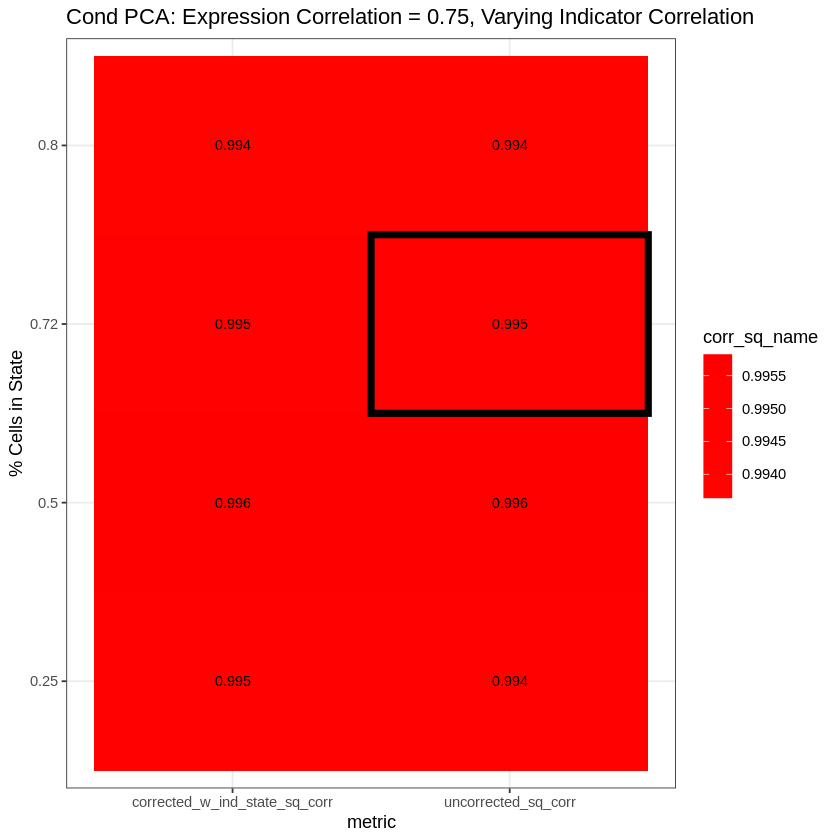

In [7]:
test = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.25, perc_genes_in_state = 1, r=0) )
test = test %>%
   group_by(metric) %>%
   summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) 
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.5, perc_genes_in_state = 1, r=0) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.72, perc_genes_in_state = 1, r=0) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.8, perc_genes_in_state = 1, r=0) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )

ggplot(test, aes(metric,as.factor(perc_cells_in_state_name), fill= corr_sq_name )) + 
  geom_tile() +scale_fill_gradient2(low = "white",
                       , mid="white", high = "red")+ geom_tile(data = test[c(6),], fill = NA, color = "black", size = 2) + geom_text(aes(label = round(corr_sq_name,3) ) , color = "black", size = 3) +ggtitle('Cond PCA: Expression Correlation = 0.75, Varying Indicator Correlation') + theme_bw()+ ylab("% Cells in State")

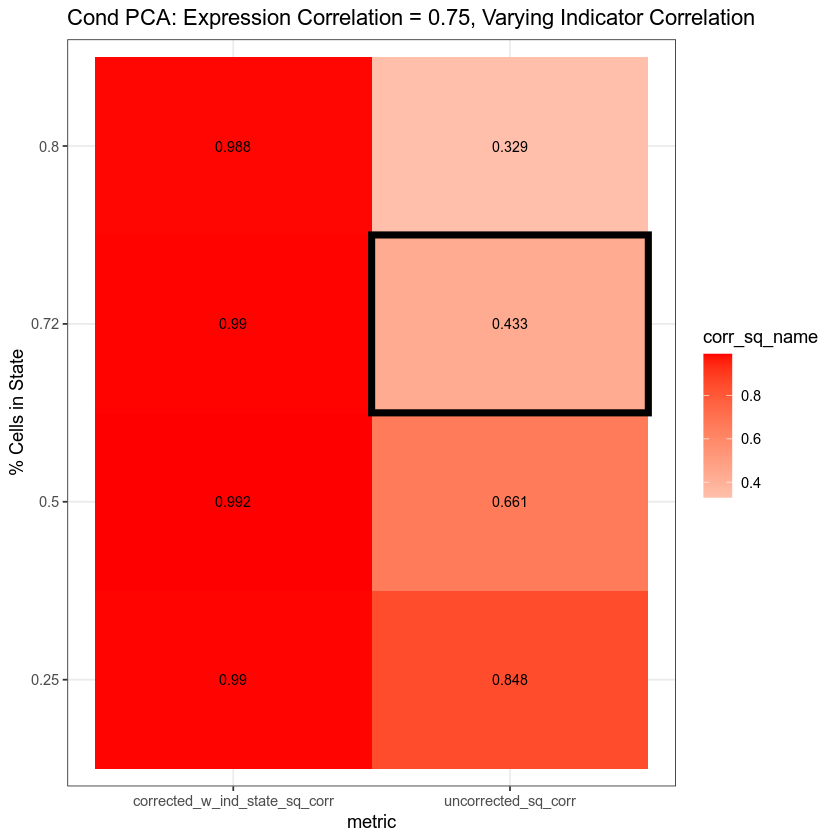

In [72]:
test = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.25, perc_genes_in_state = 1, r=0.75) )
test = test %>%
   group_by(metric) %>%
   summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) 
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.5, perc_genes_in_state = 1, r=0.75) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.72, perc_genes_in_state = 1, r=0.75) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.8, perc_genes_in_state = 1, r=0.75) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )

ggplot(test, aes(metric,as.factor(perc_cells_in_state_name), fill= corr_sq_name )) + 
  geom_tile() +scale_fill_gradient2(low = "white",
                       , mid="white", high = "red")+ geom_tile(data = test[c(6),], fill = NA, color = "black", size = 2) + geom_text(aes(label = round(corr_sq_name,3) ) , color = "black", size = 3) +ggtitle('Cond PCA: Expression Correlation = 0.75, Varying Indicator Correlation') + theme_bw()+ ylab("% Cells in State")


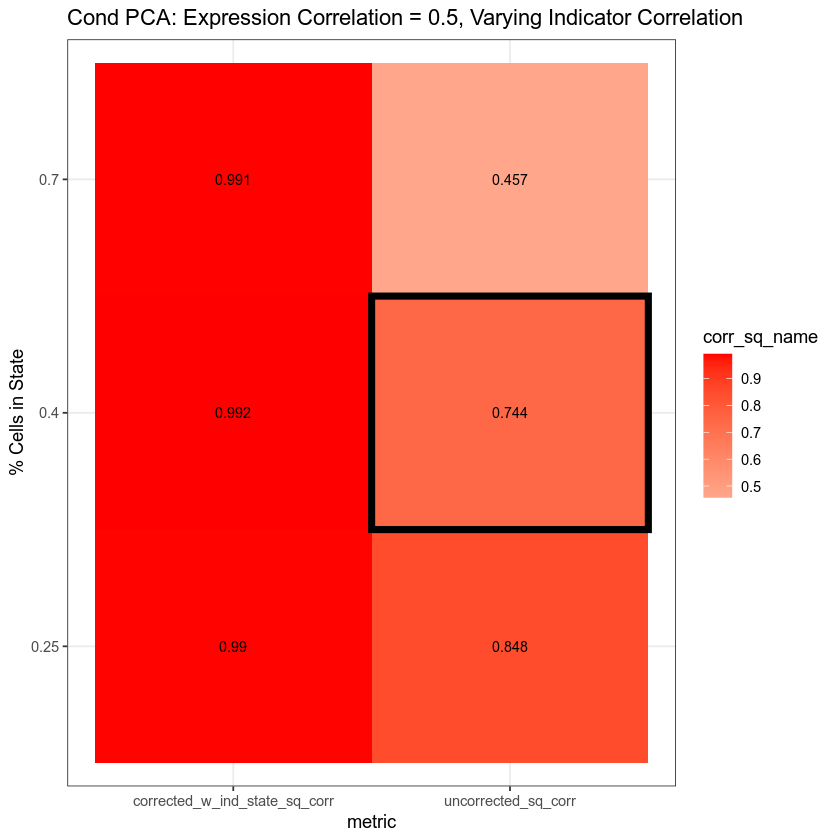

In [73]:
test = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.25, perc_genes_in_state = 1, r=0.5) )
test = test %>%
   group_by(metric) %>%
   summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) 
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.4, perc_genes_in_state = 1, r=0.5) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.7, perc_genes_in_state = 1, r=0.5) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )

ggplot(test, aes(metric,as.factor(perc_cells_in_state_name), fill= corr_sq_name )) + 
  geom_tile() + geom_tile(data = test[c(4),], fill = NA, color = "black", size = 2) + geom_text(aes(label = round(corr_sq_name,3) ) , color = "black", size = 3) +scale_fill_gradient2(low = "white",
                       , mid="white", high = "red")+ ggtitle('Cond PCA: Expression Correlation = 0.5, Varying Indicator Correlation') + theme_bw()+ ylab("% Cells in State")

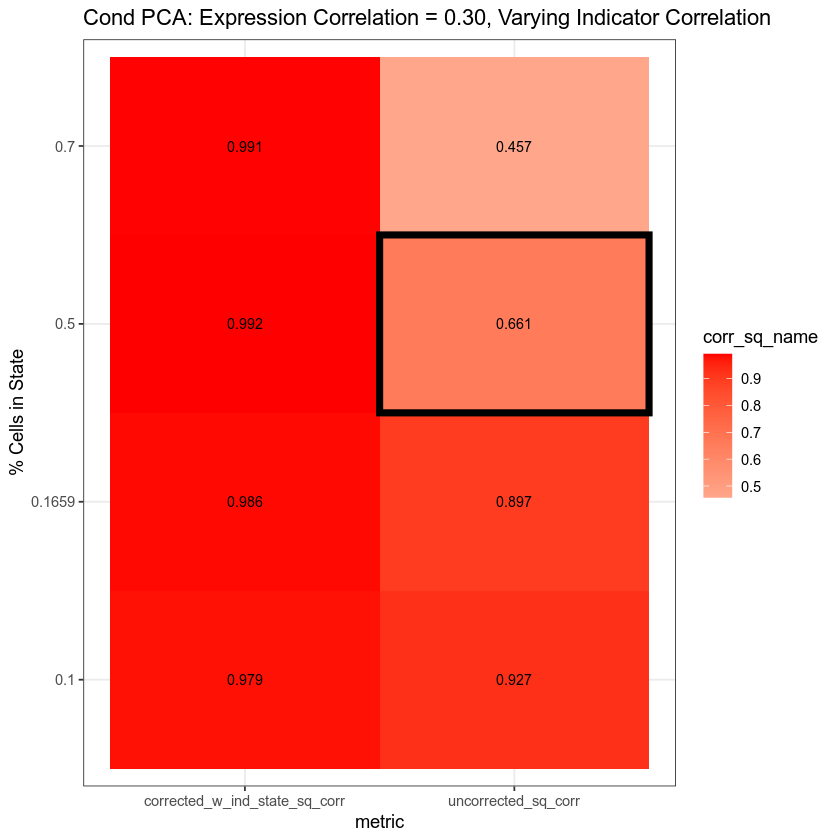

In [76]:
test = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.1, perc_genes_in_state = 1, r=0.3) )
test = test %>%
   group_by(metric) %>%
   summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) 
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.1659, perc_genes_in_state = 1, r=0.3) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.5, perc_genes_in_state = 1, r=0.3) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )
df = do.call(rbind, lapply(1:2, simulate, n=10000, m=1000, perc_cells_in_state = 0.7, perc_genes_in_state = 1, r=0.3) )
test = rbind(test, df %>%
  group_by(metric) %>%
  summarise_at(vars(n,m,perc_cells_in_state,perc_genes_in_state,corr_sq), list(name = mean)) )

ggplot(test, aes(metric,as.factor(perc_cells_in_state_name), fill= corr_sq_name )) + 
  geom_tile()+scale_fill_gradient2(low = "white",
                       , mid="white", high = "red") + geom_tile(data = test[c(6),], fill = NA, color = "black", size = 2)+ geom_text(aes(label = round(corr_sq_name,3) ) , color = "black", size = 3) +ggtitle('Cond PCA: Expression Correlation = 0.30, Varying Indicator Correlation') + theme_bw()+ ylab("% Cells in State")

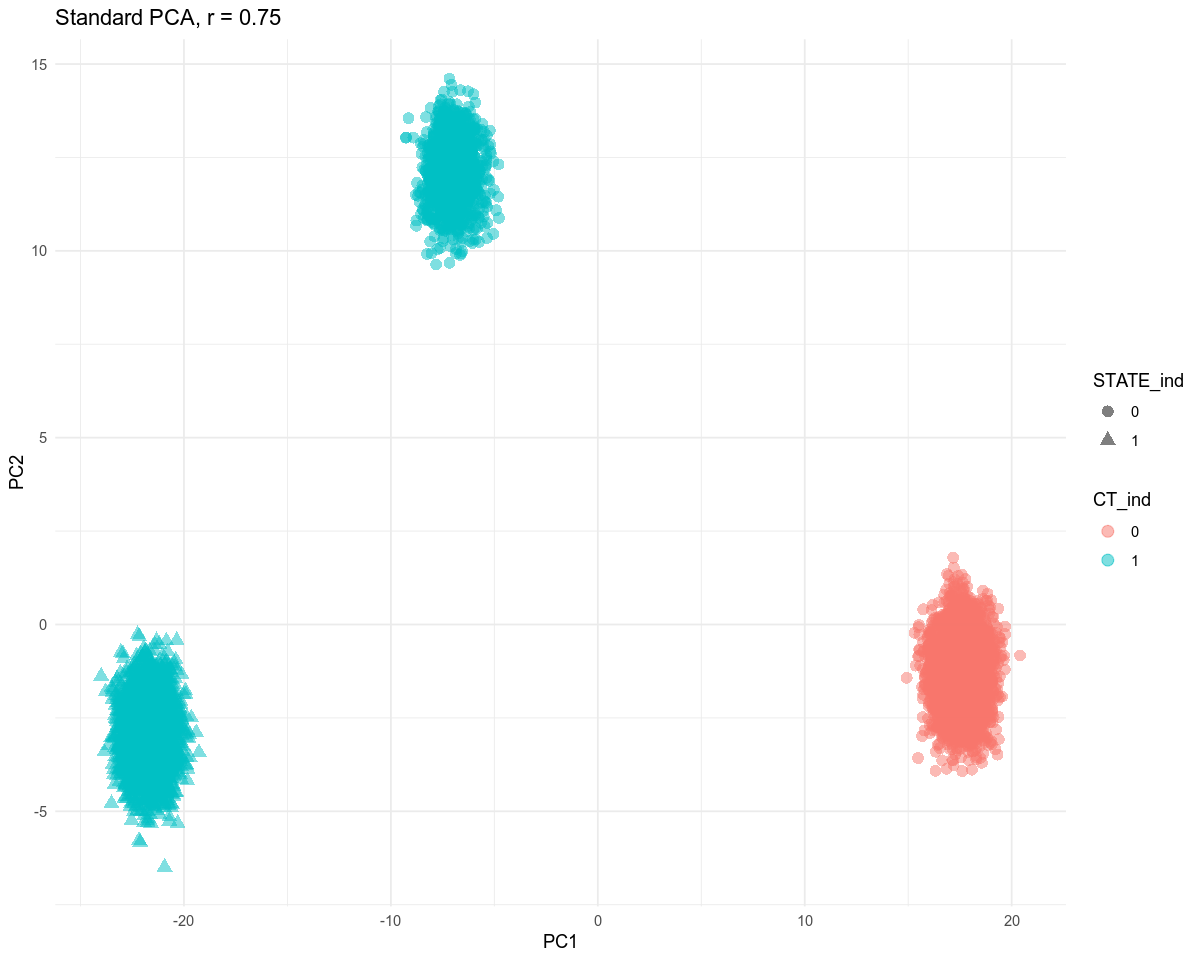

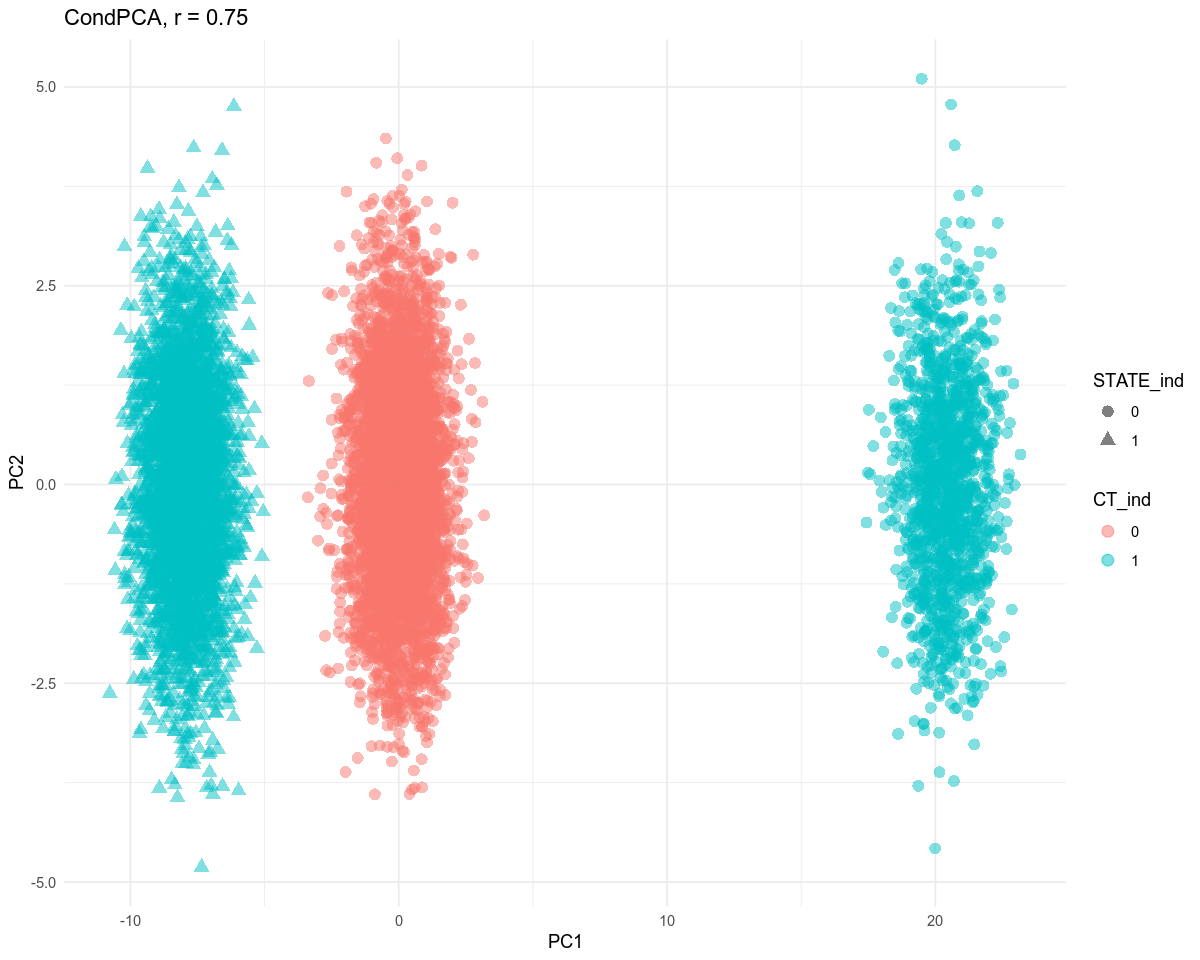

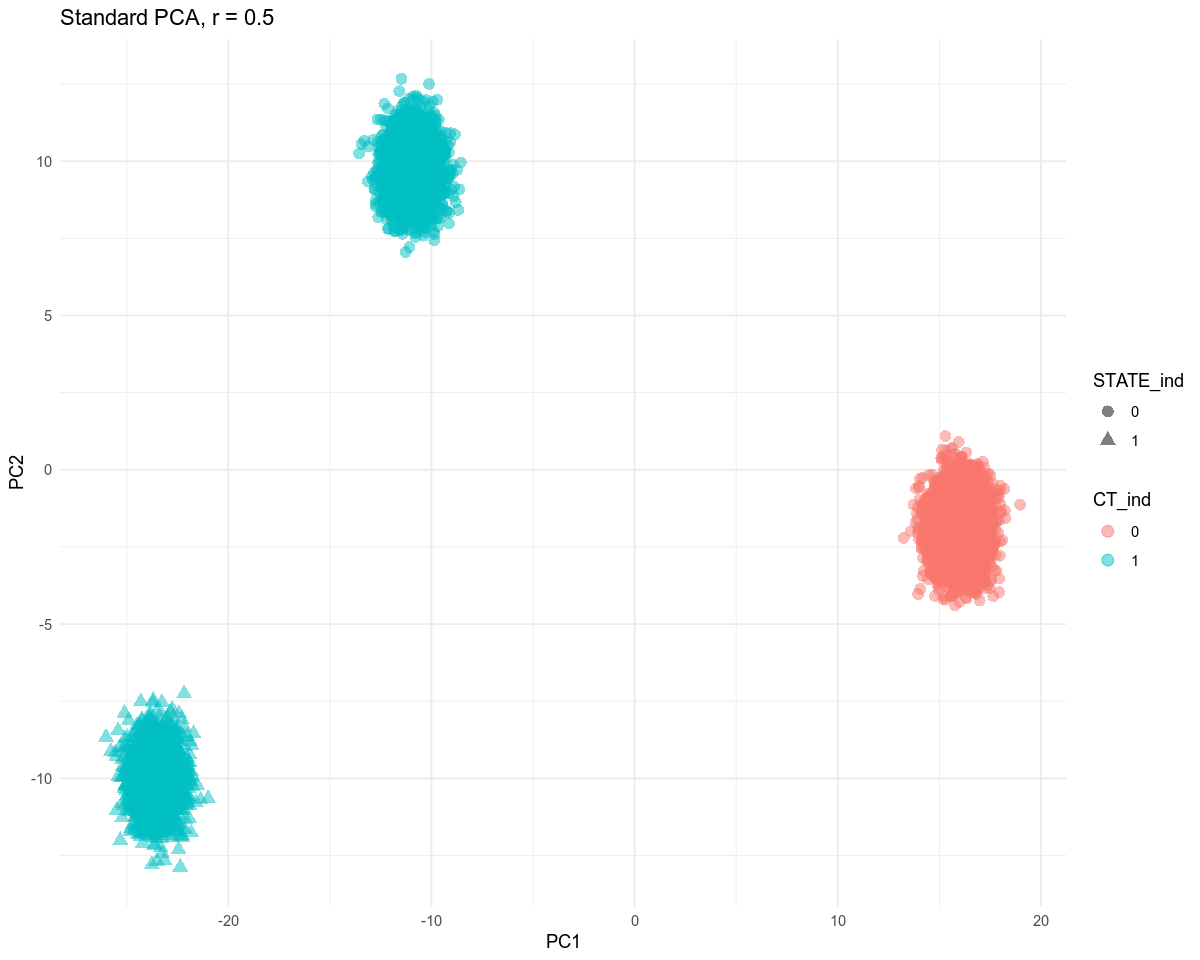

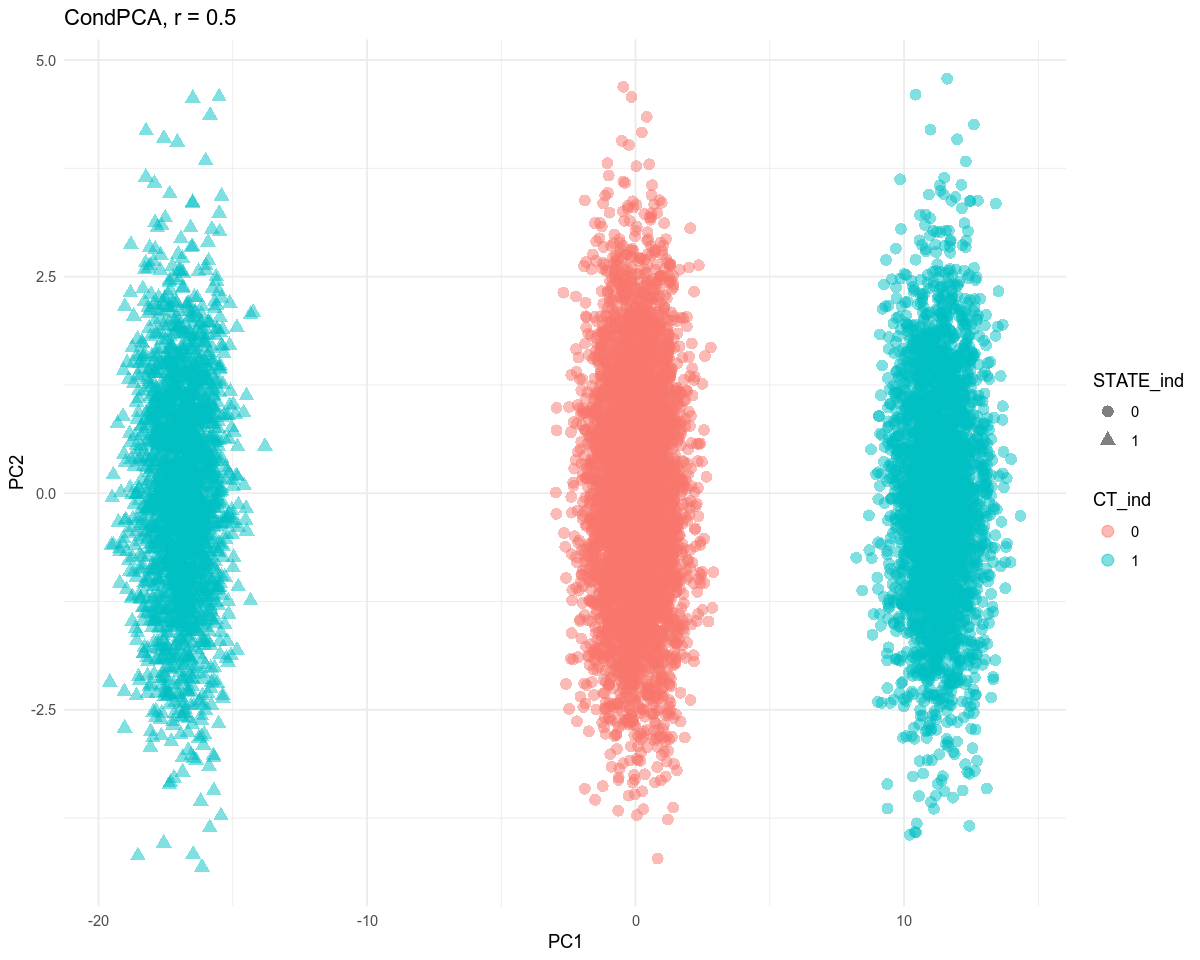

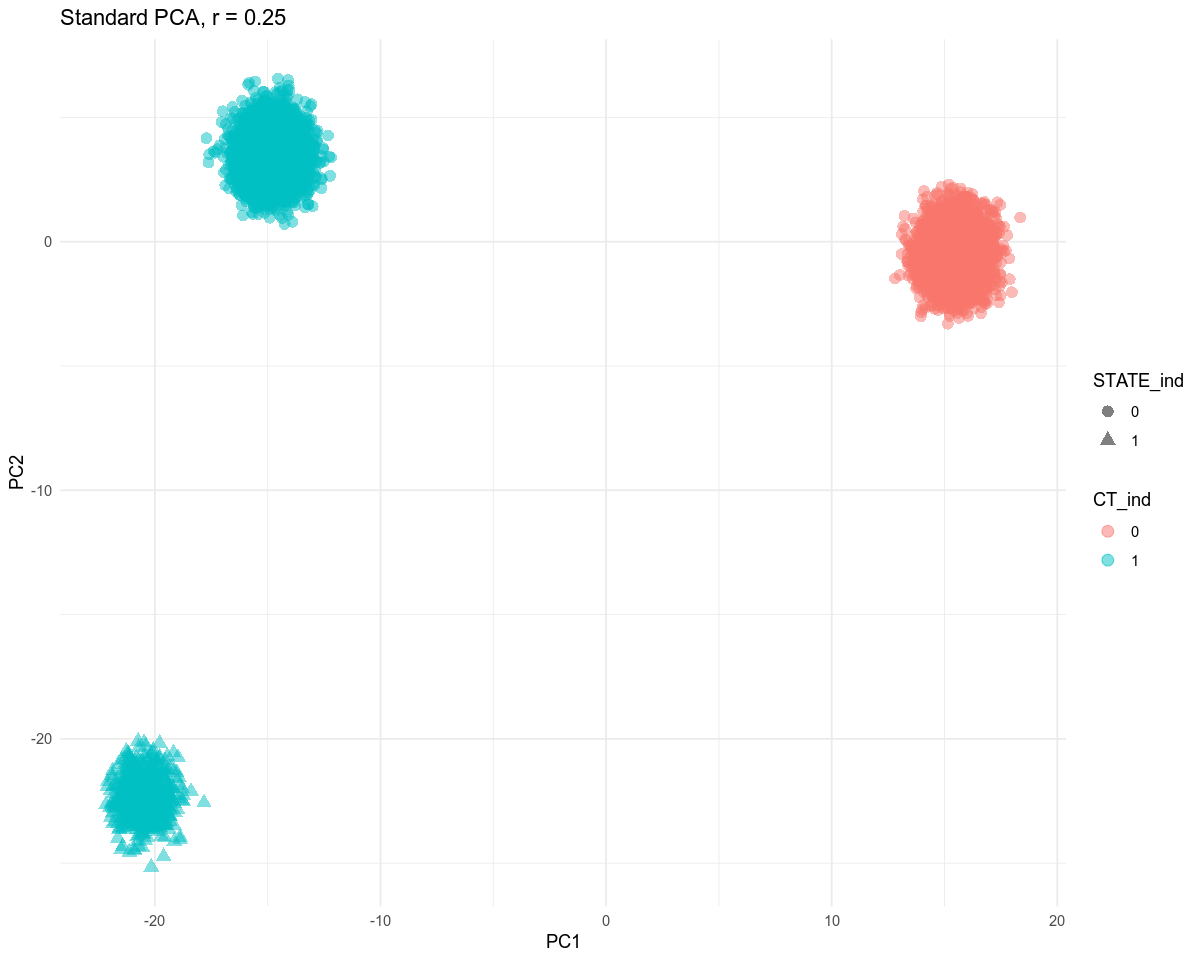

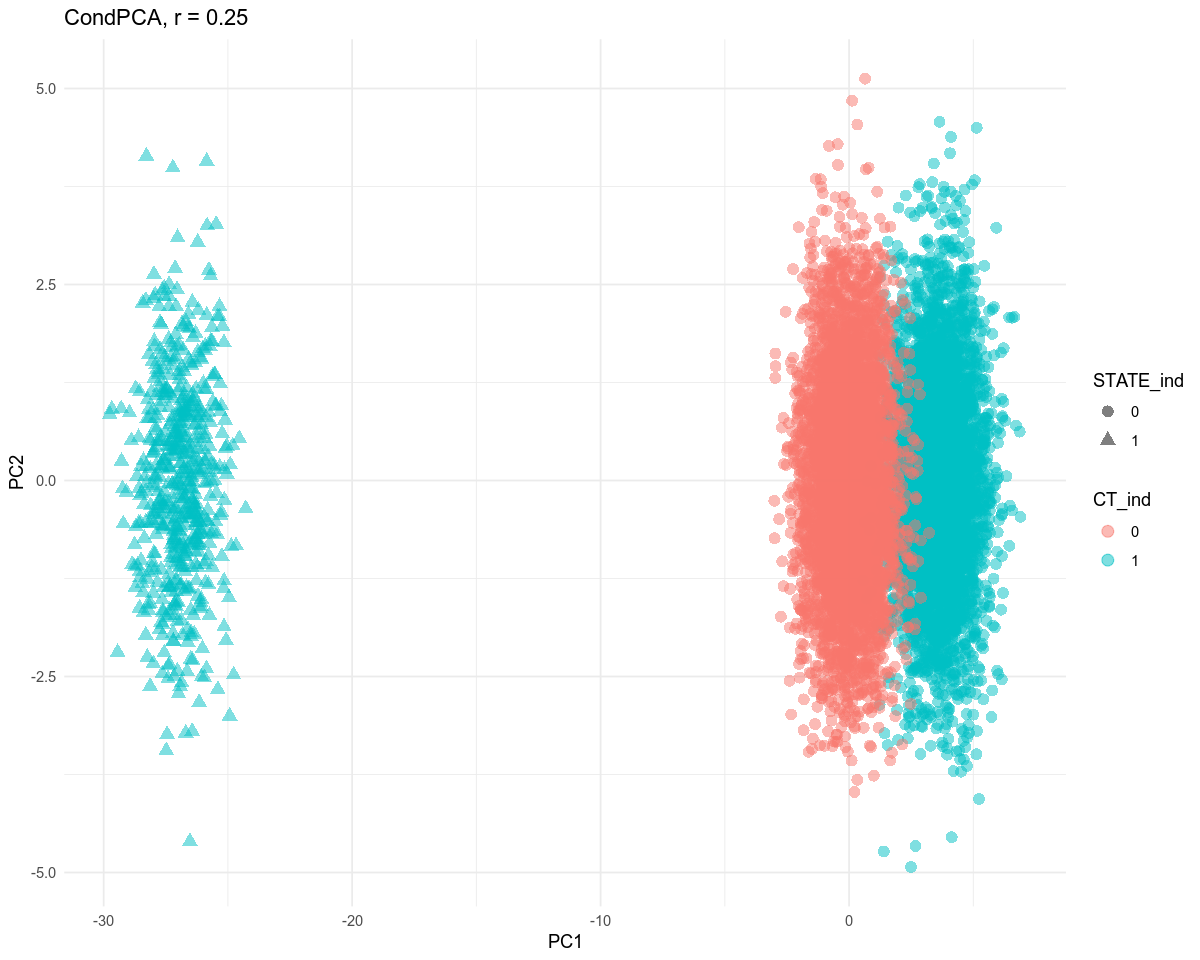

In [80]:
simulate(seed=1, n=10000, m=1000, perc_cells_in_state = 0.72, perc_genes_in_state = 1, r=0.75, to_plot=TRUE)
simulate(seed=1, n=10000, m=1000, perc_cells_in_state = 0.4, perc_genes_in_state = 1, r=0.5, to_plot=TRUE)
simulate(seed=1, n=10000, m=1000, perc_cells_in_state = 0.118, perc_genes_in_state = 1, r=0.25, to_plot=TRUE)


In [81]:
df_0.30 = do.call(rbind, lapply(1:10, simulate, n=10000, m=1000, perc_cells_in_state = 0.1659, perc_genes_in_state = 1, r=0.3) )
df_0.5 = do.call(rbind, lapply(1:10, simulate, n=10000, m=1000, perc_cells_in_state = 0.4, perc_genes_in_state = 1, r=0.5) )
df_0.75 = do.call(rbind, lapply(1:10, simulate, n=10000, m=1000, perc_cells_in_state = 0.72, perc_genes_in_state = 1, r=0.75) )



In [78]:
# df = do.call(rbind, lapply(seq(0.05,1,0.05), simulate, n=10000, m=1000,perc_genes_in_state=1) )

# ggplot(df, aes(metric,as.factor(perc_cells_in_state), fill= abs(corr) )) + 
#   geom_tile() + geom_text(aes(label = abs(round(corr,3) ) ), color = "black", size = 3) +ggtitle('Cond PCA: Absolute Value of Correlation of State vs. Uncorrected State OR Corrected State, 100% of genes in state') + theme_bw()+ ylab("% Cells in State")


# mean(df[df$metric == "uncorrected_corr",]$corr**2)

# df = t(data.frame(mapply(simulate, perc_cells_in_state= seq(0.05,1,0.05), n=10000, m=1000,perc_genes_in_state=seq(0.05,1,0.05)) ) )

# df = data.frame(df)
# corrected = cbind( data.frame(sapply(df$perc_cells_in_state,"[[",1)  ), data.frame(sapply(df$perc_genes_in_state,"[[",1)  ), data.frame(sapply(df$corr,"[[",1)  ),data.frame(sapply(df$metric,"[[",1)  ) )
# uncorrected = cbind( data.frame(sapply(df$perc_cells_in_state,"[[",2)  ), data.frame(sapply(df$perc_genes_in_state,"[[",2)  ), data.frame(sapply(df$corr,"[[",2)  ),data.frame(sapply(df$metric,"[[",2)  ) )

# colnames(corrected) = c("perc_cells_in_state","perc_genes_in_state","corr","metric")
# colnames(uncorrected) = c("perc_cells_in_state","perc_genes_in_state","corr","metric")
# df = rbind(corrected,uncorrected)

# ggplot(df, aes(metric,as.factor(perc_cells_in_state), fill= abs(corr) )) + 
#   geom_tile() + geom_text(aes(label = abs(round(corr,3) ) ), color = "black", size = 3) +ggtitle('Cond PCA: Absolute Value of Correlation of State vs. Uncorrected State OR Corrected State, 100% of genes in state') + theme_bw()+ ylab("% Cells AND Genes in State")


# Is conditional PCA consistent with the equations we derived?

$$ z_i = \mathbb{1}_i^{ct} \beta_i^{ct} +  \mathbb{1}_i^{state} \beta_i^{state} + \epsilon $$
Compute covariance between expression and CT: 

$$ z_i = \mathbb{1}_i^{ct} \alpha_i^{ct} $$

Remove Cell Type Contribution from the expression matrix --> WE ARE ABLE TO COMPUTE THIS

$$ z_i^R = z_i - \mathbb{1}_i^{ct} \hat{\alpha^{ct}} $$

Compute covariance between ct and state (if cell type is independent to state, this will be 0?) --> WE ARE NOT ABLE TO COMPUTE THIS:

$$ \mathbb{1}_i^{state} = \mathbb{1}_i^{ct} \alpha_i^{state} $$



Remove State Contribution that is correlation with Cell Type from Indicator Matrix --> WE ARE NOT ABLE TO COMPUTE THIS --> see if this aligns with loadings

$$\mathbb{1}_i^{state,R} = \mathbb{1}_i^{state}\hat{\alpha^{state}} $$

In [752]:
# # not the most helpful visual
# ggplot(df, aes(perc_cells_in_state, perc_genes_in_state, fill= corrected_w_ind_state_corr)) + 
#   geom_tile() + geom_text(aes(label = round(corrected_w_ind_state_corr,3) ), color = "black", size = 3) +ggtitle('Cond PCA: Abs(Corr(PC1, Adjusted Cell State for Cell Type Correlation))')

# ggplot(df, aes(perc_cells_in_state, perc_genes_in_state, fill= uncorrected_corr)) + 
#   geom_tile()+ geom_text(aes(label = round(uncorrected_corr,3) ), color = "black", size = 3) +ggtitle('Cond PCA: Abs(Corr(PC1, Cell State))')


# # not the most helpful visual
# ggplot(df, aes(perc_cells_in_state, perc_genes_in_state, fill= corrected_w_ind_state_corr**2)) + 
#   geom_tile() + geom_text(aes(label = round(corrected_w_ind_state_corr**2,3) ), color = "black", size = 3) +ggtitle('Cond PCA: Corr_Sq(PC1, Adjusted Cell State for Cell Type Correlation)')

# ggplot(df, aes(perc_cells_in_state, perc_genes_in_state, fill= uncorrected_corr**2)) + 
#   geom_tile()+ geom_text(aes(label = round(uncorrected_corr**2,3) ), color = "black", size = 3) +ggtitle('Hi')+ggtitle('Cond PCA: Corr_Sq(PC1, Cell State)')

Compute $\mathbb{1}_i^{state,R}$

In [531]:
ind_state_R = lm(scale(as.numeric(STATE_ind) ) ~ scale(as.numeric(CT_ind) ) )$residuals

In [532]:
cor(pca$x[,"PC1"], ind_state_R)

[1] 0.9806058

In [533]:
cor(pca$x[,"PC1"], as.numeric(STATE_ind) )

[1] 0.693445